In [ ]:
# Install required modules
!pip install --upgrade --quiet arango-datasets

!pip install --upgrade --quiet nx_arangodb

!pip install --upgrade --quiet nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com

!pip install --upgrade --quiet  langchain langchain-openai langchain-community langgraph langgraph.prebuilt

In [2]:
# Import required modules
import networkx as nx
import nx_arangodb as nxadb
import os
from arango import ArangoClient


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import re

[02:43:11 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


# Convert and load data for NetworkX:

In [ ]:
# Download the Synthea dataset
url = "https://synthetichealth.github.io/synthea-sample-data/downloads/latest/synthea_sample_data_csv_latest.zip"
zip_path = "synthea_data.zip"
extract_folder = "synthea_data"

if not os.path.exists(zip_path):
  print("Downloading Synthea data")
  !wget -O {zip_path} {url}

if not os.path.exists(extract_folder):
  print("Extracting files")
  !unzip -o {zip_path} -d {extract_folder}

patients_file = os.path.join(extract_folder, "patients.csv")
allergies_file = os.path.join(extract_folder, "allergies.csv")
conditions_file = os.path.join(extract_folder, "conditions.csv")
careplans_file = os.path.join(extract_folder, "careplans.csv")

# Read CSVs
patients_df = pd.read_csv(patients_file)
allergies_df = pd.read_csv(allergies_file)
conditions_df = pd.read_csv(conditions_file)
careplans_df = pd.read_csv(careplans_file)

# Create graphs
patients_allergies_graph = nx.Graph()
patients_conditions_graph = nx.Graph()
patients_careplans_graph = nx.Graph()

# Add patient nodes
for _, row in patients_df.iterrows():
    patient_id = row["Id"]
    patients_allergies_graph.add_node(
        patient_id,
        type="patient",
        firstname=row["FIRST"],
        lastname=row["LAST"],
        gender=row["GENDER"],
        birthdate=row["BIRTHDATE"],
        race=row["RACE"],
        ethnicity=row["ETHNICITY"],
        birthplace=row["BIRTHPLACE"],
        address=row["ADDRESS"],
        city=row["CITY"],
        state=row["STATE"],
        county=row["COUNTY"],
        lat=row["LAT"],
        lon=row["LON"],
        healthcare_expenses=row["HEALTHCARE_EXPENSES"],
        healthcare_coverage=row["HEALTHCARE_COVERAGE"],
        income=row["INCOME"])
    patients_conditions_graph.add_node(
        patient_id,
        type="patient",
        firstname=row["FIRST"],
        lastname=row["LAST"],
        gender=row["GENDER"],
        birthdate=row["BIRTHDATE"],
        race=row["RACE"],
        ethnicity=row["ETHNICITY"],
        birthplace=row["BIRTHPLACE"],
        address=row["ADDRESS"],
        city=row["CITY"],
        state=row["STATE"],
        county=row["COUNTY"],
        lat=row["LAT"],
        lon=row["LON"],
        healthcare_expenses=row["HEALTHCARE_EXPENSES"],
        healthcare_coverage=row["HEALTHCARE_COVERAGE"],
        income=row["INCOME"])
    patients_careplans_graph.add_node(
        patient_id,
        type="patient",
        firstname=row["FIRST"],
        lastname=row["LAST"],
        gender=row["GENDER"],
        birthdate=row["BIRTHDATE"],
        race=row["RACE"],
        ethnicity=row["ETHNICITY"],
        birthplace=row["BIRTHPLACE"],
        address=row["ADDRESS"],
        city=row["CITY"],
        state=row["STATE"],
        county=row["COUNTY"],
        lat=row["LAT"],
        lon=row["LON"],
        healthcare_expenses=row["HEALTHCARE_EXPENSES"],
        healthcare_coverage=row["HEALTHCARE_COVERAGE"],
        income=row["INCOME"])

# Add allergy nodes and has_allergy edges
for _, row in allergies_df.iterrows():
    allergy_code = row["CODE"]
    patient_id = row["PATIENT"]

    if allergy_code not in patients_allergies_graph:
      patients_allergies_graph.add_node(
          allergy_code,
          type="allergy",
          description=row["DESCRIPTION"],
          category=row["CATEGORY"])

    patients_allergies_graph.add_edge(patient_id, allergy_code)

# Add condition nodes and has_condition edges
for _, row in conditions_df.iterrows():
  condition_code = row["CODE"]
  patient_id = row["PATIENT"]

  if condition_code not in patients_conditions_graph:
    patients_conditions_graph.add_node(
      condition_code,
      type="condition",
      description=row["DESCRIPTION"])

  patients_conditions_graph.add_edge(patient_id, condition_code)

# Add careplan nodes and has_careplan edges
for _, row in careplans_df.iterrows():
  careplan_code = row["CODE"]
  patient_id = row["PATIENT"]

  if careplan_code not in patients_careplans_graph:
    patients_careplans_graph.add_node(
        careplan_code,
        type="careplan",
        description=row["DESCRIPTION"]
    )

  patients_careplans_graph.add_edge(patient_id, careplan_code)

# Extract nodes for our adb collections
patients_data = [
    {"_key": node, **patients_allergies_graph.nodes[node]}
    for node in patients_allergies_graph.nodes if patients_allergies_graph.nodes[node]["type"] == "patient"
]

allergies_data = [
    {"_key": str(node), **patients_allergies_graph.nodes[node]}
    for node in patients_allergies_graph.nodes if patients_allergies_graph.nodes[node]["type"] == "allergy"
]

p_allergies_edges_data = [
    {"_from": f"patients/{u}", "_to": f"allergies/{v}"}
    for u, v in patients_allergies_graph.edges
]

conditions_data = [
    {"_key": str(node), **patients_conditions_graph.nodes[node]}
    for node in patients_conditions_graph.nodes if patients_conditions_graph.nodes[node]["type"] == "condition"
]

p_conditions_edges_data = [
    {"_from": f"patients/{u}", "_to": f"conditions/{v}"}
    for u, v in patients_conditions_graph.edges
]

careplans_data = [
    {"_key": str(node), **patients_careplans_graph.nodes[node]}
    for node in patients_careplans_graph.nodes if patients_careplans_graph.nodes[node]["type"] == "careplan"
]

p_careplans_edges_data = [
    {"_from": f"patients/{u}", "_to": f"careplans/{v}"}
    for u, v in patients_careplans_graph.edges
]

--2025-03-07 00:42:08--  https://synthetichealth.github.io/synthea-sample-data/downloads/latest/synthea_sample_data_csv_latest.zip
Resolving synthetichealth.github.io (synthetichealth.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to synthetichealth.github.io (synthetichealth.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7991968 (7.6M) [application/zip]
Saving to: ‘synthea_data.zip’

synthea_data.zip    100%[===================>]   7.62M  --.-KB/s    in 0.07s   

2025-03-07 00:42:08 (107 MB/s) - ‘synthea_data.zip’ saved [7991968/7991968]

Extracting files
Archive:  synthea_data.zip
  inflating: synthea_data/supplies.csv  
  inflating: synthea_data/allergies.csv  
  inflating: synthea_data/procedures.csv  
  inflating: synthea_data/claims_transactions.csv  
  inflating: synthea_data/medications.csv  
  inflating: synthea_data/payers.csv  
  inflating: synthea_data/claims.csv  
  inflating: synthea_da

Graph loaded with 123 nodes and 92 edges.
Example patient node: 30a6452c-4297-a1ac-977a-6a23237c7b46
Example allergy node: 419199007


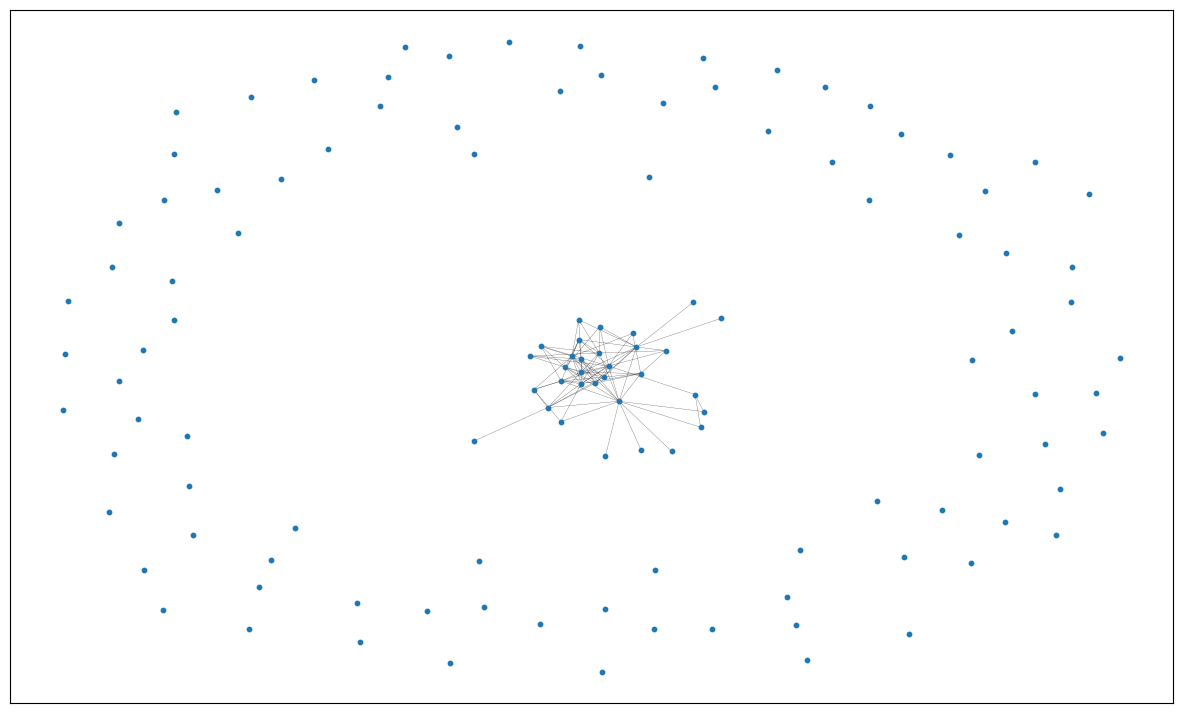

In [ ]:
print(f"Graph loaded with {patients_allergies_graph.number_of_nodes()} nodes and {patients_allergies_graph.number_of_edges()} edges.")
print("Example patient node:", next(n for n in patients_allergies_graph.nodes if patients_allergies_graph.nodes[n]['type'] == "patient"))
print("Example allergy node:", next(n for n in patients_allergies_graph.nodes if patients_allergies_graph.nodes[n]['type'] == "allergy"))

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(patients_allergies_graph, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(patients_allergies_graph, pos=pos, ax=ax, **plot_options)

Graph loaded with 281 nodes and 2007 edges.
Example patient node: 30a6452c-4297-a1ac-977a-6a23237c7b46
Example condition node: 105531004


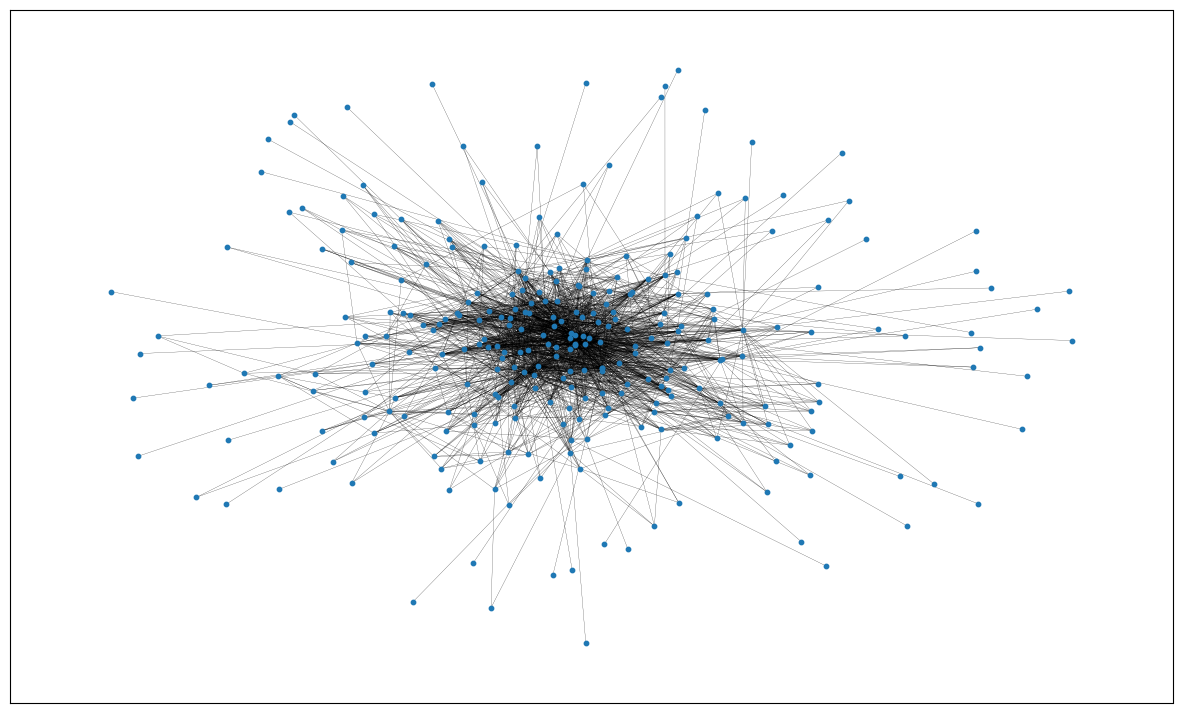

In [ ]:
print(f"Graph loaded with {patients_conditions_graph.number_of_nodes()} nodes and {patients_conditions_graph.number_of_edges()} edges.")
print("Example patient node:", next(n for n in patients_conditions_graph.nodes if patients_conditions_graph.nodes[n]['type'] == "patient"))
print("Example condition node:", next(n for n in patients_conditions_graph.nodes if patients_conditions_graph.nodes[n]['type'] == "condition"))

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(patients_conditions_graph, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(patients_conditions_graph, pos=pos, ax=ax, **plot_options)

Graph loaded with 136 nodes and 291 edges.
Example patient node: 30a6452c-4297-a1ac-977a-6a23237c7b46
Example careplan node: 385691007


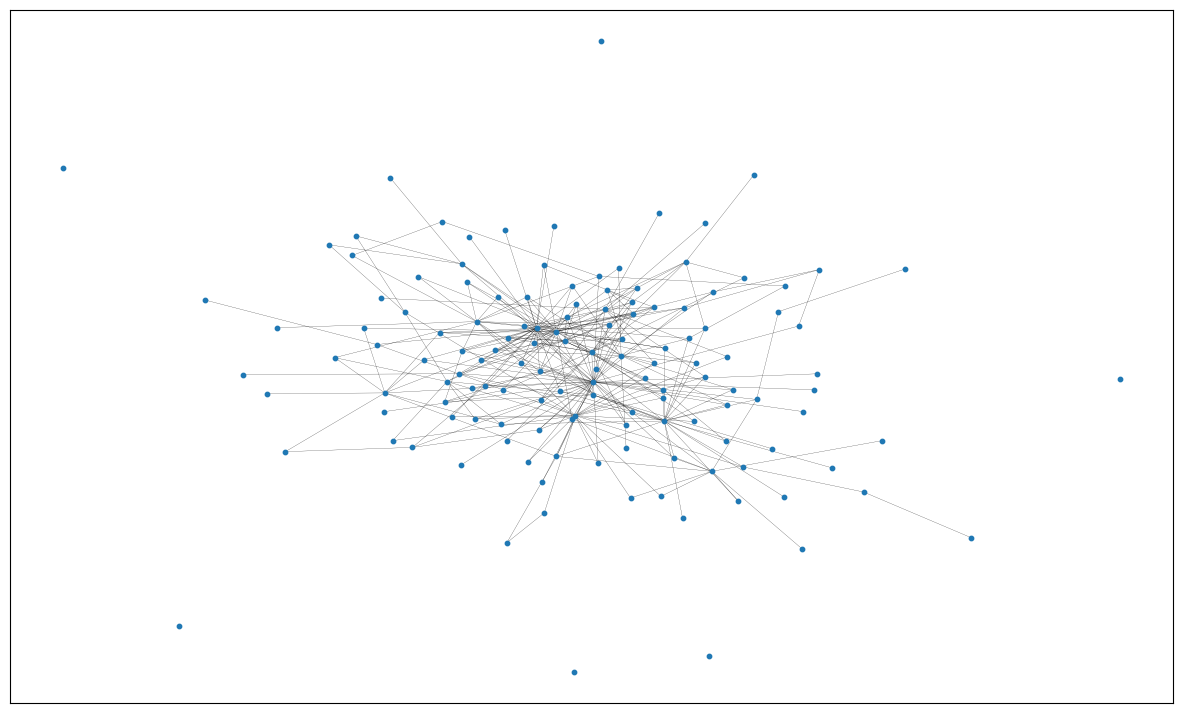

In [ ]:
print(f"Graph loaded with {patients_careplans_graph.number_of_nodes()} nodes and {patients_careplans_graph.number_of_edges()} edges.")
print("Example patient node:", next(n for n in patients_careplans_graph.nodes if patients_careplans_graph.nodes[n]['type'] == "patient"))
print("Example careplan node:", next(n for n in patients_careplans_graph.nodes if patients_careplans_graph.nodes[n]['type'] == "careplan"))

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(patients_careplans_graph, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(patients_careplans_graph, pos=pos, ax=ax, **plot_options)

# Persist graph into ArangoDB:

In [3]:
from arango_datasets import Datasets
from google.colab import userdata

db_host = userdata.get('DB_HOST')
db_pass = userdata.get('DB_PASS')

# Connect to database
db = ArangoClient(hosts=db_host).db(username="root", password=db_pass, verify=True)

# Connect to datasets
datasets = Datasets(db)

Output()

In [ ]:
# Load data into ArangoDB
db.create_collection("patients")

db.create_collection("allergies")
db.create_collection("has_allergy", edge=True)

db.create_collection("conditions")
db.create_collection("has_condition", edge=True)

db.create_collection("careplans")
db.create_collection("has_careplan", edge=True)

# Insert into collections
patients_collection = db.collection("patients")

allergies_collection = db.collection("allergies")
has_allergy_collection = db.collection("has_allergy")

conditions_collection = db.collection("conditions")
has_condition_collection = db.collection("has_condition")

careplans_collection = db.collection("careplans")
has_careplan_collection = db.collection("has_careplan")

# Insert patients
patients_collection.import_bulk(patients_data, overwrite=True)

# Insert allergies
allergies_collection.import_bulk(allergies_data, overwrite=True)

# Insert conditions
conditions_collection.import_bulk(conditions_data, overwrite=True)

# Insert careplans
careplans_collection.import_bulk(careplans_data, overwrite=True)

# Insert edges
has_allergy_collection.import_bulk(p_allergies_edges_data, overwrite=True)
has_condition_collection.import_bulk(p_conditions_edges_data, overwrite=True)
has_careplan_collection.import_bulk(p_careplans_edges_data, overwrite=True)

In [ ]:
# Create graphs in ArangoDB
patients_allergies_adb = db.create_graph("patients_allergies_graph")

patients_allergies_adb.create_vertex_collection("patients")
patients_allergies_adb.create_vertex_collection("allergies")

patients_allergies_adb.create_edge_definition(
    edge_collection="has_allergy",
    from_vertex_collections=["patients"],
    to_vertex_collections=["allergies"]
)

patients_conditions_adb = db.create_graph("patients_conditions_graph")

patients_conditions_adb.create_vertex_collection("patients")
patients_conditions_adb.create_vertex_collection("conditions")

patients_conditions_adb.create_edge_definition(
    edge_collection="has_condition",
    from_vertex_collections=["patients"],
    to_vertex_collections=["conditions"]
)

patients_careplans_adb = db.create_graph("patients_careplans_graph")

patients_careplans_adb.create_vertex_collection("patients")
patients_careplans_adb.create_vertex_collection("careplans")

patients_careplans_adb.create_edge_definition(
    edge_collection="has_careplan",
    from_vertex_collections=["patients"],
    to_vertex_collections=["careplans"]
)

# Create views
db.create_arangosearch_view(
    name='allergy_view',
    properties={'cleanupIntervalStep': 0,
                'links':{'allergies':{
                          'includeAllFields': True,
                          'analyzers': ['text_en']
                          }
                        }
                }
)

db.create_arangosearch_view(
    name='condition_view',
    properties={'cleanupIntervalStep': 0,
                'links':{'conditions':{
                          'includeAllFields': True,
                          'analyzers': ['text_en']
                          }
                        }
                }
)

db.create_arangosearch_view(
    name='careplan_view',
    properties={'cleanupIntervalStep': 0,
                'links':{'careplans':{
                          'includeAllFields': True,
                          'analyzers': ['text_en']
                          }
                        }
                }
)

{'global_id': 'h603F24AE9EB6/1055423',
 'id': '1055423',
 'name': 'careplan_view',
 'type': 'arangosearch',
 'cleanup_interval_step': 0,
 'commit_interval_msec': 1000,
 'consolidation_interval_msec': 1000,
 'consolidation_policy': {'type': 'tier',
  'segments_min': 1,
  'segments_max': 10,
  'segments_bytes_max': 5368709120,
  'segments_bytes_floor': 2097152,
  'min_score': 0},
 'primary_sort': [],
 'primary_sort_compression': 'lz4',
 'stored_values': [],
 'writebuffer_idle': 64,
 'writebuffer_active': 0,
 'writebuffer_max_size': 33554432,
 'links': {'careplans': {'analyzers': ['text_en'],
   'fields': {},
   'includeAllFields': True,
   'storeValues': 'none',
   'trackListPositions': False}},
 'optimizeTopK': []}

In [5]:
# Connect to our graphs
patients_allergies_graph = nxadb.Graph(name="patients_allergies_graph", db=db)
patients_conditions_graph = nxadb.Graph(name="patients_conditions_graph", db=db)
patients_careplans_graph = nxadb.Graph(name="patients_careplans_graph", db=db)

print(patients_allergies_graph)
print(patients_conditions_graph)
print(patients_careplans_graph)

[02:44:16 +0000] [INFO]: Graph 'patients_allergies_graph' exists.
INFO:nx_arangodb:Graph 'patients_allergies_graph' exists.
[02:44:16 +0000] [INFO]: Default node type set to 'allergies'
INFO:nx_arangodb:Default node type set to 'allergies'
[02:44:16 +0000] [INFO]: Graph 'patients_conditions_graph' exists.
INFO:nx_arangodb:Graph 'patients_conditions_graph' exists.
[02:44:16 +0000] [INFO]: Default node type set to 'conditions'
INFO:nx_arangodb:Default node type set to 'conditions'
[02:44:17 +0000] [INFO]: Graph 'patients_careplans_graph' exists.
INFO:nx_arangodb:Graph 'patients_careplans_graph' exists.
[02:44:17 +0000] [INFO]: Default node type set to 'careplans'
INFO:nx_arangodb:Default node type set to 'careplans'


Graph named 'patients_allergies_graph' with 123 nodes and 92 edges
Graph named 'patients_conditions_graph' with 281 nodes and 2007 edges
Graph named 'patients_careplans_graph' with 136 nodes and 291 edges


# Build the agentic app:

In [6]:
from langchain_community.graphs import ArangoGraph
from langchain_openai import ChatOpenAI
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

arango_graph = ArangoGraph(db)

print(arango_graph.schema)

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

{'Graph Schema': [{'graph_name': 'patients_allergies_graph', 'edge_definitions': [{'edge_collection': 'has_allergy', 'from_vertex_collections': ['patients'], 'to_vertex_collections': ['allergies']}]}, {'graph_name': 'patients_conditions_graph', 'edge_definitions': [{'edge_collection': 'has_condition', 'from_vertex_collections': ['patients'], 'to_vertex_collections': ['conditions']}]}, {'graph_name': 'patients_careplans_graph', 'edge_definitions': [{'edge_collection': 'has_careplan', 'from_vertex_collections': ['patients'], 'to_vertex_collections': ['careplans']}]}], 'Collection Schema': [{'collection_name': 'patients', 'collection_type': 'document', 'document_properties': [{'name': '_key', 'type': 'str'}, {'name': '_id', 'type': 'str'}, {'name': '_rev', 'type': 'str'}, {'name': 'type', 'type': 'str'}, {'name': 'firstname', 'type': 'str'}, {'name': 'lastname', 'type': 'str'}, {'name': 'gender', 'type': 'str'}, {'name': 'birthdate', 'type': 'str'}, {'name': 'race', 'type': 'str'}, {'name

In [7]:
@tool
def text_to_aql_to_nx_algorithm_to_txt(query: str):
    """Use this hybrid tool first before any other tools, if appropriate.
    This tool translates a Natural Language Query to AQL, executes it, and returns
    the result back as Natural Language. Then the results of the AQL query are passed to
    invoke a NetworkX Algorithm on the ArangoDB Graph, the results of which
    are translated back to Natural Language with respect to the original query.

    For example, if you think a NetworkX algorithm is needed,
    and you want to find a specific node by searching by 'description': do not
    do that. Instead, be more accurate by using AQL to find the specific key
    number for that node that matches the description first, and then invoke
    NetworkX algorithms with that newly found key. This is just one example,
    there may be other situations that call for AQL before NetworkX.

    In general, we want to make use of our available Views (e.g., allergy_view)
    which have full text search capabilities available to be more accurate in our
    querying.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating and running AQL query")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )

    text_to_aql_to_text = chain.invoke(f"""
    I have the following query: {query}

    There's also access to ArangoSearch views called 'allergy_view',
    'condition_view', and 'careplan_view', useful for searching for keys of
    nodes by description.

    If the AQL query you are building involves the description property
    (e.g. condition.description), rewrite query to use FILTER,
    CONTAINS, and LOWER to look for matches for the description. Never
    use == to look for description matches. For example, when looking for
    condition.description for "sinusitis", the query should contain
    FILTER CONTAINS(LOWER(condition.description), "sinusitis").

    Stop the chain once you find the answers you need.
    """)

    print('-'*10)
    print(str(text_to_aql_to_text["text_to_aql_to_text"]))

    ######################

    print("\n2) Executing NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have NetworkX Graphs called `patients_allergies_graph`, 'patients_conditions_graph', 'patients_careplans_graph'.
    It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}. I also have additional information from an already executed AQL query based off
    of our query: {str(text_to_aql_to_text["text_to_aql_to_text"])}. Use these results. For example, if you are looking for a specific
    allergy, use the key or code number found by the AQL query we already performed so we do not redo any work we've already done.

    I also have ArangoSearch views called 'allergy_view','condition_view', and 'careplan_view'.

    Generate the Python Code required to answer the query using the appropriate graph object. Do not generate any code that
    looks for results that we already have from our executed AQL query ({str(text_to_aql_to_text["result"])}).

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Select the best NetworkX algorithm for the query (e.g., centrality, clustering, similarity).

    Only assume that networkx is installed, and other base python dependencies.

    If using Jaccard, use neighbors() instead of predecessors() or successors()

    If there are errors, give detailed information on what went wrong including the original error message.

    If no errors, always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    If no errors, only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    If no errors, make sure that `FINAL_RESULT` stores a short & concise answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"patients_allergies_graph": patients_allergies_graph, "patients_conditions_graph": patients_conditions_graph,
                   "patients_careplans_graph": patients_careplans_graph, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: code corrector
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have NetworkX Graphs called `patients_allergies_graph`, 'patients_conditions_graph', 'patients_careplans_graph'.
        It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
    """).content

    return nx_to_text


In [8]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )

    result = chain.invoke(f"""
    I have the following query: {query}

    There's also access to ArangoSearch views called 'allergy_view',
    'condition_view', and 'careplan_view', useful for searching for keys of
    nodes by description.

    If the AQL query you are building involves the DESCRIPTION property
    (e.g. condition.DESCRIPTION), rewrite query to use FILTER,
    CONTAINS, and LOWER to look for matches for the DESCRIPTION. Never
    use == to look for DESCRIPTION matches. For example, when looking for
    condition.DESCRIPTION for "sinusitis", the query should contain
    FILTER CONTAINS(LOWER(condition.DESCRIPTION), "sinusitis").
    """)

    return str(result["result"])

In [9]:
@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool. Only use NetworkX for advanced graph analytics (centrality, clustering, similarity, influence propagation, etc.).

    This tool should only be used for graph analytics tasks that AQL cannot efficiently handle, such as:
    - Centrality Analysis (e.g., betweenness, closeness, eigenvector)
    - Community Detection (e.g., Louvain, k-clique, label propagation)
    - Graph Similarity & Structural Comparisons (e.g., Jaccard)
    - Influence Propagation & Evolution Analysis
    - Graph Clustering & Component Detection
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have NetworkX Graphs called `patients_allergies_graph`, 'patients_conditions_graph', 'patients_careplans_graph'.
    It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    I also have ArangoSearch views called 'allergy_view','condition_view', and 'careplan_view'.

    Generate the Python Code required to answer the query using the the appropriate graph object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Select the best NetworkX algorithm for the query (e.g., centrality, clustering, similarity).

    Only assume that networkx is installed, and other base python dependencies.

    If using Jaccard, use neighbors() instead of predecessors() or successors()

    If there are errors, give detailed information on what went wrong including the original error message.

    If no errors, always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    If no errors, only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    If no errors, make sure that `FINAL_RESULT` stores a short & concise answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"patients_allergies_graph": patients_allergies_graph, "patients_conditions_graph": patients_conditions_graph,
                   "patients_careplans_graph": patients_careplans_graph, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: code corrector
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have NetworkX Graphs called `patients_allergies_graph`, 'patients_conditions_graph', 'patients_careplans_graph'.
        It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
    """).content

    return nx_to_text

In [10]:
# Creates the Agentic app

tools = [text_to_aql_to_nx_algorithm_to_txt, text_to_aql_to_text, text_to_nx_algorithm_to_text]

def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from gradio import ChatMessage

theme = gr.themes.Base(
    primary_hue="emerald",
    secondary_hue="emerald",
)

image_url = "https://i.ibb.co/0p7tNfX3/cohort-lens-logo.png"

def interact_with_agent(prompt, history):
    messages = []
    messages.append(ChatMessage(role="user", content=prompt))
    yield messages
    msg = query_graph(prompt)
    messages.append(ChatMessage(role="assistant", content=msg))
    yield messages

with gr.Blocks() as chat:
    gr.Markdown(f"""
        <div style="text-align: center;">
            <img src="{image_url}" alt="Cohort Lens logo" style="width: 20%; max-width: 100px; border-radius: 10px;">
        </div>
    """)
    gr.Markdown("# Cohort Lens")

    chatbot = gr.Chatbot(label="Agent",
                         type="messages",
                         avatar_images=(None, image_url))
    text_input = gr.Textbox(lines=1, label="Chat Message")
    text_input.submit(interact_with_agent, [text_input, chatbot], [chatbot])

chat.launch(share=True, debug=True)

# Sample queries

In [ ]:
query_graph("Use clustering to find me participants for an allergy study and list them. Explain why these patients are suitable beyond just sharing the same allergy with a detailed summary")

1) Generating NetworkX code
----------
import networkx as nx

# Assuming patients_allergies_graph is already defined and populated
G = patients_allergies_graph

# Step 1: Use a clustering algorithm to identify clusters in the allergy graph
# We will use the Girvan-Newman algorithm to find communities in the graph
communities_generator = nx.community.girvan_newman(G)

# Step 2: Get the first level of communities (clusters)
top_level_communities = next(communities_generator)

# Step 3: Convert the communities to a list of sets
clusters = [set(c) for c in top_level_communities]

# Step 4: Analyze the clusters to determine suitability for the allergy study
# For simplicity, let's assume that larger clusters are more suitable for the study
# because they represent a larger group of patients with shared characteristics

# Find the largest cluster
largest_cluster = max(clusters, key=len)

# Step 5: Prepare the final result
FINAL_RESULT = f"Identified {len(largest_cluster)} patients suitable f

'I have identified a list of patients who are potential candidates for an allergy study. Here are the participants:\n\n1. Caryl Kassulke\n2. Princess Schmeler\n3. Kimbery Schuppe\n4. Dolly Franecki\n5. German Ebert\n6. Hershel Labadie\n7. Berta Alemán\n8. Faustino Robel\n9. Hershel Grant\n10. Ulysses Schiller\n\nThese patients have been identified based on their documented allergy to a specific substance. Beyond just sharing the same allergy, these individuals may have other common factors such as similar demographic profiles, medical histories, or environmental exposures that make them suitable for the study. However, to provide a more detailed summary of why these patients are particularly suitable, additional data analysis would be required to explore these factors further.'

In [ ]:
query_graph("Perform Jaccard similarity to find me a group of participants for a tree pollen study. Even if no suitable group is found, return value of variables like allergy_node and patients_with_allergy")

1) Generating and running AQL query


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH patients, allergies, has_allergy

LET allergy_node = FIRST(
    FOR allergy IN allergies
        FILTER CONTAINS(LOWER(allergy.description), "tree pollen")
        RETURN allergy
)

LET patients_with_allergy = (
    FOR patient IN patients
        FOR edge IN has_allergy
            FILTER edge._from == patient._id AND edge._to == allergy_node._id
            RETURN patient
)

RETURN {
    allergy_node: allergy_node,
    patients_with_allergy: patients_with_allergy
}

AQL Result:
[{'allergy_node': {'_key': '782576004', '_id': 'allergies/782576004', '_rev': '_jU2Lxmi--C', 'type': 'allergy', 'description': 'Tree pollen (substance)', 'category': 'environment'}, 'patients_with_allergy': [{'_key': '4569671e-ed39-055f-8e78-422b96c9896b', '_id': 'patients/4569671e-ed39-055f-8e78-422b96c9896b', '_rev': '_jU2Lxku--E', 'type': 'patient', 'firstname': 'Caryl47', 'lastname': 'Kassulke119', 'gender'

"The analysis provided the following results:\n\n1. **Allergy Node and Patients with Tree Pollen Allergy:**\n   - The allergy node related to tree pollen was identified, and the following patients have this allergy:\n     1. Fabian Hayes\n     2. Truman Hermiston\n     3. Ulysses Schiller\n     4. Hershel Grant\n     5. Faustino Robel\n     6. Hershel Labadie\n     7. German Ebert\n     8. Caryl Kassulke\n\n2. **Jaccard Similarity Analysis:**\n   - The Jaccard similarity analysis on the `patients_allergies_graph` identified the pair of patients with the highest similarity in their allergy profiles as:\n     - 'patients/bf40c2b4-4f0d-10cf-a2bb-cbb235e4e437'\n     - 'patients/14dc5e57-1b84-3305-c042-86c9fc7e4996'\n   - These patients are the most suitable participants for the tree pollen study based on their shared allergy characteristics."

In [ ]:
query_graph("Who has tree pollen allergy in our database?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH patients, allergies, has_allergy
FOR allergy IN allergy_view
    FILTER CONTAINS(LOWER(allergy.description), "tree pollen")
    FOR v, e, p IN 1..1 INBOUND allergy._id has_allergy
        RETURN v

AQL Result:
[{'_key': 'de480ca4-19a6-f2e0-7922-1c51e7c8dcb8', '_id': 'patients/de480ca4-19a6-f2e0-7922-1c51e7c8dcb8', '_rev': '_jU2Lxku-_J', 'type': 'patient', 'firstname': 'Fabian647', 'lastname': 'Hayes766', 'gender': 'M', 'birthdate': '2017-01-08', 'race': 'white', 'ethnicity': 'nonhispanic', 'birthplace': 'Boston  Massachusetts  US', 'address': '896 Jerde Stravenue Suite 72', 'city': 'Waltham', 'state': 'Massachusetts', 'county': 'Middlesex County', 'lat': 42.34289958791842, 'lon': -71.24213987981395, 'healthcare_expenses': 7380.74, 'healthcare_coverage': 12883.79, 'income': 33617}, {'_key': 'c1ce8dfc-3c0d-de97-ce0e-5dc0460da340', '_id': 'patients/c1ce8dfc-3c0d-de97-ce0e-5dc0460da340', '_rev': '_jU2Lxku--3', 'type': 'patien

'The following patients in our database have a tree pollen allergy:\n\n1. **Fabian Hayes** - Male, born on January 8, 2017, residing in Waltham, Massachusetts.\n2. **Truman Hermiston** - Male, born on May 12, 1997, residing in Hudson, Massachusetts.\n3. **Ulysses Schiller** - Male, born on September 1, 1972, residing in Dennis, Massachusetts.\n4. **Hershel Grant** - Male, born on March 30, 1984, residing in Somerville, Massachusetts.\n5. **Faustino Robel** - Male, born on March 21, 1955, residing in Needham, Massachusetts.\n6. **Hershel Labadie** - Male, born on August 5, 2010, residing in Southborough, Massachusetts.\n7. **German Ebert** - Male, born on November 15, 1961, residing in Tisbury, Massachusetts.\n8. **Caryl Kassulke** - Female, born on August 10, 2013, residing in Arlington, Massachusetts.\n\nThese patients are located in various counties across Massachusetts.'

In [ ]:
query_graph("What is the most common condition for patients in the database?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH patients, conditions, has_condition
FOR condition IN conditions
    LET patientCount = (
        FOR v, e IN 1..1 INBOUND condition has_condition
            COLLECT WITH COUNT INTO count
            RETURN count
    )
    SORT patientCount DESC
    LIMIT 1
    RETURN {
        condition: condition.description,
        count: FIRST(patientCount)
    }

AQL Result:
[{'condition': 'Medication review due (situation)', 'count': 106}]

> Finished chain.


'The most common condition among patients in the database is "Medication review due (situation)," which affects 106 patients.'

In [ ]:
query_graph("Find me cohorts of patients based on shared allergies")

1) Generating and running AQL query


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH patients, allergies, has_allergy
FOR allergy IN allergies
    FOR patient IN patients
        FOR edge IN has_allergy
            FILTER edge._from == patient._id
            FILTER edge._to == allergy._id
            COLLECT sharedAllergy = allergy.description INTO patientGroups
            RETURN {
                allergy: sharedAllergy,
                patients: patientGroups[*].patient
            }

AQL Result:
[{'allergy': 'Allergy to substance (finding)', 'patients': [{'_key': '4569671e-ed39-055f-8e78-422b96c9896b', '_id': 'patients/4569671e-ed39-055f-8e78-422b96c9896b', '_rev': '_jU2Lxku--E', 'type': 'patient', 'firstname': 'Caryl47', 'lastname': 'Kassulke119', 'gender': 'F', 'birthdate': '2013-08-10', 'race': 'white', 'ethnicity': 'nonhispanic', 'birthplace': 'East Falmouth  Massachusetts  US', 'address': '578 Dickens Camp', 'city': 'Arlington', 'state': 'Massachusetts', 'count

'The graph analysis identified 46 patient cohorts who share similar allergies using the Jaccard Coefficient. This indicates that there are groups of patients with overlapping allergy profiles. If you need more detailed information about these cohorts, please let me know!'